https://www.kaggle.com/xhlulu/ranzcr-efficientnet-gpu-starter-train-submit

Pre-trained Densenet Network of 121 layers. Densenet was used by *Stanford ML group* for pneumonia detection from Chest X-Ray images (hence called "**CheXnet**" which achieved significant accuracy score (radiologist level). Since the images are of same nature, the same network can perform well here also. Let's watch! 

In [1]:
import numpy as np 
import pandas as pd 
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (Input, MaxPooling2D, BatchNormalization,
                                    GlobalAveragePooling2D, Dense, Conv2D,
                                    Dropout, Flatten, Activation, ZeroPadding2D,
                                    Add)
from tensorflow.keras import activations
from tensorflow.keras.models import Model

from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets

import matplotlib.pyplot as plt
%matplotlib inline
import gc
import tempfile


In [2]:
def auto_select_accelerator():
    
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy


def build_decoder(with_labels=True, target_size=(512,512), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        
        img = tf.cast(img, tf.float32) / 255.0
        
        img = tf.image.resize(img,target_size, 
                              method=tf.image.ResizeMethod.BICUBIC,
                              antialias=True)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.70, 1.30)
        img = tf.image.random_contrast(img, 0.80, 1.20)
        img = tf.image.random_brightness(img, 0.10)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [3]:
COMPETITION_NAME = "ranzcr-clip-catheter-line-classification"
strategy = auto_select_accelerator()
BATCH_SIZE = strategy.num_replicas_in_sync * 16
GCS_DS_PATH = KaggleDatasets().get_gcs_path(COMPETITION_NAME)

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [4]:
load_dir = f"/kaggle/input/{COMPETITION_NAME}/"
df = pd.read_csv(load_dir + 'train.csv')

# paths = load_dir + "train/" + df['StudyInstanceUID'] + '.jpg'
paths = GCS_DS_PATH + "/train/" + df['StudyInstanceUID'] + '.jpg'

sub_df = pd.read_csv(load_dir + 'sample_submission.csv')

# test_paths = load_dir + "test/" + sub_df['StudyInstanceUID'] + '.jpg'
test_paths = GCS_DS_PATH + "/test/" + sub_df['StudyInstanceUID'] + '.jpg'

# Get the multi-labels
label_cols = sub_df.columns[1:]
labels = df[label_cols].values

In [5]:
(
    train_paths, valid_paths, 
    train_labels, valid_labels
) = train_test_split(paths, labels, test_size=0.2, random_state=42)

In [6]:
im_size = 512

decoder = build_decoder(with_labels=True, target_size=(im_size, im_size))
test_decoder = build_decoder(with_labels=False, target_size=(im_size, im_size))

train_dataset = build_dataset(
    train_paths, train_labels, bsize=BATCH_SIZE, decode_fn=decoder
)

valid_dataset = build_dataset(
    valid_paths, valid_labels, bsize=BATCH_SIZE, decode_fn=decoder,
    repeat=False, shuffle=False, augment=False
)

test_dataset = build_dataset(
    test_paths, cache=False, bsize=BATCH_SIZE, decode_fn=test_decoder,
    repeat=False, shuffle=False, augment=False
)

In [7]:
with strategy.scope():
    model = tf.keras.Sequential()
    #inputs = Input(shape=(224,224,3))
    base_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                   weights='imagenet',
                                                   input_shape=(512,512,3))
    model.add(base_model)
    
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(11,activation='sigmoid'))
            
    def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

        if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
          print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
          return model

        for layer in model.layers:
            for attr in ['kernel_regularizer']:
                if hasattr(layer, attr):
                  setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
        model_json = model.to_json()

    # Save the weights before reloading the model.
        tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
        model.save_weights(tmp_weights_path)

    # load the model from the config
        model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
        model.load_weights(tmp_weights_path, by_name=True)
        return model
    
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                22539     
Total params: 21,825,323
Trainable params: 21,790,891
Non-trainable params: 34,432
_________________________________________________________________


In [8]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(multi_label=True)])

In [9]:
steps_per_epoch = train_paths.shape[0] // BATCH_SIZE
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model2.h5', save_best_only=True, monitor='val_auc', mode='max')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", patience=3, min_lr=1e-6, mode='max')

print("Batch size: {}".format(BATCH_SIZE))
print("Steps per epoch: {}".format(steps_per_epoch))

Batch size: 128
Steps per epoch: 188


In [10]:
history = model.fit(
    train_dataset, 
    epochs=30,
    callbacks=[checkpoint, lr_reducer],
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset)

Epoch 1/30
188/188 [==============================] - 1147s 6s/step - loss: 0.2570 - auc: 0.7495 - val_loss: 0.3147 - val_auc: 0.7119
Epoch 2/30
188/188 [==============================] - 67s 358ms/step - loss: 0.2054 - auc: 0.8378 - val_loss: 0.2587 - val_auc: 0.8304
Epoch 3/30
188/188 [==============================] - 66s 352ms/step - loss: 0.1849 - auc: 0.8814 - val_loss: 0.2072 - val_auc: 0.8722
Epoch 4/30
188/188 [==============================] - 66s 352ms/step - loss: 0.1734 - auc: 0.8988 - val_loss: 0.1861 - val_auc: 0.8855
Epoch 5/30
188/188 [==============================] - 67s 357ms/step - loss: 0.1648 - auc: 0.9113 - val_loss: 0.1766 - val_auc: 0.9098
Epoch 6/30
188/188 [==============================] - 66s 353ms/step - loss: 0.1585 - auc: 0.9139 - val_loss: 0.1635 - val_auc: 0.9128
Epoch 7/30
188/188 [==============================] - 66s 352ms/step - loss: 0.1527 - auc: 0.9243 - val_loss: 0.1764 - val_auc: 0.9057
Epoch 8/30
188/188 [==============================] - 67

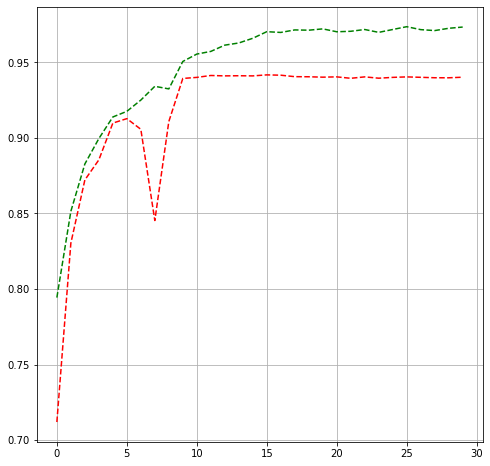

In [11]:
plt.figure(figsize=(8,8))
plt.grid()
plt.plot(history.history['auc'],'g--')
plt.plot(history.history['val_auc'],'r--')

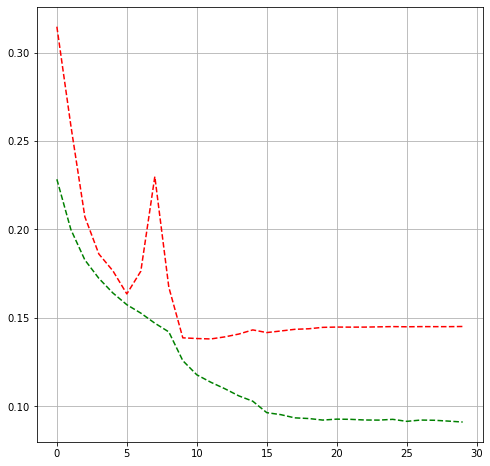

In [12]:
plt.figure(figsize=(8,8))
plt.grid()
plt.plot(history.history['loss'],'g--')
plt.plot(history.history['val_loss'],'r--')

In [14]:
model_name = "InceptionV3_R1_V1.h5"
model.save(model_name)